In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud as wc

from string import punctuation as p
from collections import Counter as cnt 
from nltk.tokenize import word_tokenize as wt

from nltk.corpus import stopwords
from gensim import corpora
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer as tfidf
from sklearn.model_selection import train_test_split,GridSearchCV as gsv
from sklearn.metrics import accuracy_score,classification_report,f1_score,auc,roc_curve,\
confusion_matrix,log_loss,precision_score,recall_score,mean_squared_error

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
spam= pd.read_csv("C:\\Users\\mishr\\fr_projects\\mail\\messages.csv")
spam.sample(7)

,subject,message,label
371,response to the linguist list query . . .,"several weeks ago , i submitted the following ...",0
2656,possible + 900 % stock investment return !,"as stock investing interests you , please care...",1
1846,bu conf . on lang . dev .,the 23nd annual boston university conference o...,0
1491,australian linguistics institute,final call papers for presentation ali ' 98 wo...,0
1868,call for participation rochebrune 1999,call for participation rochebrune 1999 journee...,0
2271,really cool but very hot videos !,attention ! warning ! adults only ! warning ! ...,1
1265,special issue jetai,call for papers journal of experimental and th...,0


In [3]:
spam.isnull().sum()

subject    62
message     0
label       0
dtype: int64

In [4]:
spam.fillna(" ",inplace =True)

In [5]:
spam['mail']=spam['subject']+" "+ spam['message']

spam.drop(['subject','message'],axis=1,inplace=True)

spam['len of uncleaned']= spam['mail'].str.len().astype('int64')


spam['label'].astype('int64')


spam.tail(7)

,label,mail,len of uncleaned
2886,1,"from fanny , recommending nek dear sir or mada...",3049
2887,1,"win $ 300usd and a cruise ! raquel 's casino ,...",823
2888,1,love your profile - ysuolvpv hello thanks for ...,291
2889,1,you have been asked to join kiddin the list ow...,2198
2890,0,anglicization of composers ' names judging fro...,1074
2891,0,"re : 6 . 797 , comparative method : n - ary co...",3004
2892,0,re : american - english in australia hello ! i...,737


In [6]:
spam.dtypes

label                int64
mail                object
len of uncleaned     int64
dtype: object

In [7]:
spam.isnull().sum()

label               0
mail                0
len of uncleaned    0
dtype: int64

In [8]:
spam.shape

(2893, 3)

In [9]:
spam.duplicated().sum()

17

In [10]:
spam.drop_duplicates(keep='first',inplace=True)

In [11]:
spam.shape

(2876, 3)

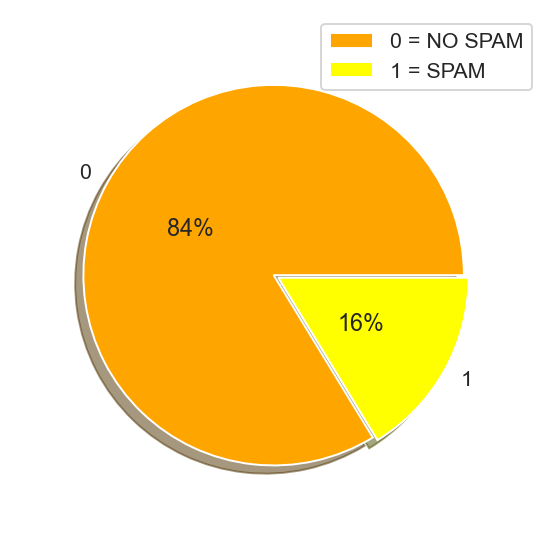

In [12]:
lb=spam['label'].value_counts().index.tolist()
val=spam['label'].value_counts().values.tolist()
exp=(0.025,0)
clr=('orange','yellow')
plt.figure(figsize=(10,5),dpi=140)
sns.set_context('talk',font_scale=0.4)
sns.set(style='whitegrid')
plt.pie(x=val,explode=exp,labels=lb,colors=clr,autopct='%2.0f%%',pctdistance=0.5, shadow=True,radius=0.9)
plt.legend(["0 = NO SPAM",'1 = SPAM'])
plt.show()

In [13]:
#CONVRTING EVERYTHING TO LOWERCASE
spam['mail']=spam['mail'].str.lower()

#REPLACING NEXT LINES BY 'WHITE SPACE'
spam['mail']=spam['mail'].str.replace(r'\n'," ") 


# REPLACING EMAIL IDs BY 'MAILID'
spam['mail'] = spam['mail'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','MailID')


# REPLACING URLs  BY 'Links'
spam['mail']= spam['mail'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','Links')


# REPLACING CURRENCY SIGNS BY 'MONEY'
spam['mail'] = spam['mail'].str.replace(r'£|\$', 'Money')


# REPLACING LARGE WHITE SPACE BY SINGLE WHITE SPACE
spam['mail'] = spam['mail'].str.replace(r'\s+', ' ')


# REPLACING LEADING AND TRAILING WHITE SPACE BY SINGLE WHITE SPACE
spam['mail'] = spam['mail'].str.replace(r'^\s+|\s+?$', '')


#REPLACING CONTACT NUMBERS
spam['mail'] = spam['mail'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','contact number')



#REPLACING NUMBERS
spam['mail'] = spam['mail'].str.replace(r'\d+(\.\d+)?', 'numbers')



#REPLACING SPECIAL CHARACTERS  BY WHITE SPACE 
spam['mail']=spam['mail'].str.replace(r"[^a-zA-Z0-9]+", " ") 

In [14]:
spam.head()

,label,mail,len of uncleaned
0,0,job posting apple iss research center content ...,2896
1,0,lang classification grimes joseph e and barbar...,1802
2,0,query letter frequencies for text identificati...,1486
3,0,risk a colleague and i are researching the dif...,329
4,0,request book information earlier this morning ...,1071


In [15]:
print(spam['mail'][12:18])

12    korean software for macintosh dear sir madam w...
13    syntax the antisymmetry of syntax richard s ka...
14    simultaneous prepositions and postpositions in...
15    sum imperatives without you subjects content l...
16    policies moderators message a very happy numbe...
17     correction to hellenistic greek announcement ...
Name: mail, dtype: object


In [16]:
#CREATING A FUNCTION FOR REMOVING STOPWORDS, PUNCTUATION MARKS 
def clean(text):
    cleaned_mail=[]
    for i in wt(text):        
            if not i in stopwords.words('english') :
                cleaned_mail.append(i) 
    return (" ".join([x for x in cleaned_mail])).strip()

In [17]:
#TESTING THE FUNCTION CREATED
text="Phishing is a scam where criminals typically send emails to thousands of people. These emails pretend to come from \
banks, credit card companies, online shops and auction sites as well as other trusted organisations. They usually try to\
trick you into going to the site, for example to update your password to avoid your account being suspended. The embedded \
link in the email itself goes to a website that looks exactly like the real thing but is actually a fake designed to trick\
victims into entering personal information. "
TEXT=text.lower()
print(clean(TEXT))

phishing scam criminals typically send emails thousands people . emails pretend come banks , credit card companies , online shops auction sites well trusted organisations . usually try totrick going site , example update password avoid account suspended . embedded link email goes website looks exactly like real thing actually fake designed trickvictims entering personal information .


In [18]:
%%time
cleaned = []

for i in spam['mail']:
    cleaned.append(clean(i))

Wall time: 9min 52s


In [19]:
print("Length of cleaned text=\t",len(cleaned))
print(cleaned[:7])

Length of cleaned text=	 2876
['job posting apple iss research center content length numbers apple iss research center us Money numbers million joint venture apple computer inc institute systems science national university singapore located singapore looking senior speech scientist successful candidate research expertise computational linguistics including natural language processing english chinese statistical language modeling knowledge state art corpus based n gram language models cache language models part speech language models required text speech project leader successful candidate research expertise expertise two following areas computational linguistics including natural language parsing lexical database design statistical language modeling text tokenization normalization prosodic analysis substantial knowledge phonology syntax semantics chinese required knowledge acoustic phonetics speech signal processing desirable candidates phd least numbers numbers years relevant work exp

In [20]:
#USING THE EXTRACTED FEATURE AS MAIL
processed = pd.DataFrame({'cleaned mail' : cleaned })
#spam['mail']= pd.concat([spam, processed], axis = 1)
spam['mail']= processed
spam.head(10)

,label,mail,len of uncleaned
0,0,job posting apple iss research center content ...,2896
1,0,lang classification grimes joseph e barbara f ...,1802
2,0,query letter frequencies text identification p...,1486
3,0,risk colleague researching differing degrees r...,329
4,0,request book information earlier morning phone...,1071
5,0,call abstracts optimality syntactic theory con...,4544
6,0,scandinavian linguistics scandinavian linguist...,2237
7,0,call papers linguistics session mla call paper...,855
8,0,foreign language commercials content length nu...,1262
9,0,fulbright announcement please post disseminate...,1538


In [21]:
spam.isnull().sum()

label                0
mail                17
len of uncleaned     0
dtype: int64

In [22]:
spam.dropna(inplace=True)

In [23]:
spam['len of cleaned']=spam['mail'].str.len()
spam['len of cleaned'].astype('int64')
spam.head(5)

,label,mail,len of uncleaned,len of cleaned
0,0,job posting apple iss research center content ...,2896,2109
1,0,lang classification grimes joseph e barbara f ...,1802,1490
2,0,query letter frequencies text identification p...,1486,1149
3,0,risk colleague researching differing degrees r...,329,215
4,0,request book information earlier morning phone...,1071,654


In [24]:
#CALCULATING
print('Original Length = ',spam['len of uncleaned'].sum())
print('Clean Length =  ', spam['len of cleaned'].sum())
print('Total Reduction = ',spam['len of uncleaned'].sum()-spam['len of cleaned'].sum())

Original Length =  9337235
Clean Length =   6763516
Total Reduction =  2573719


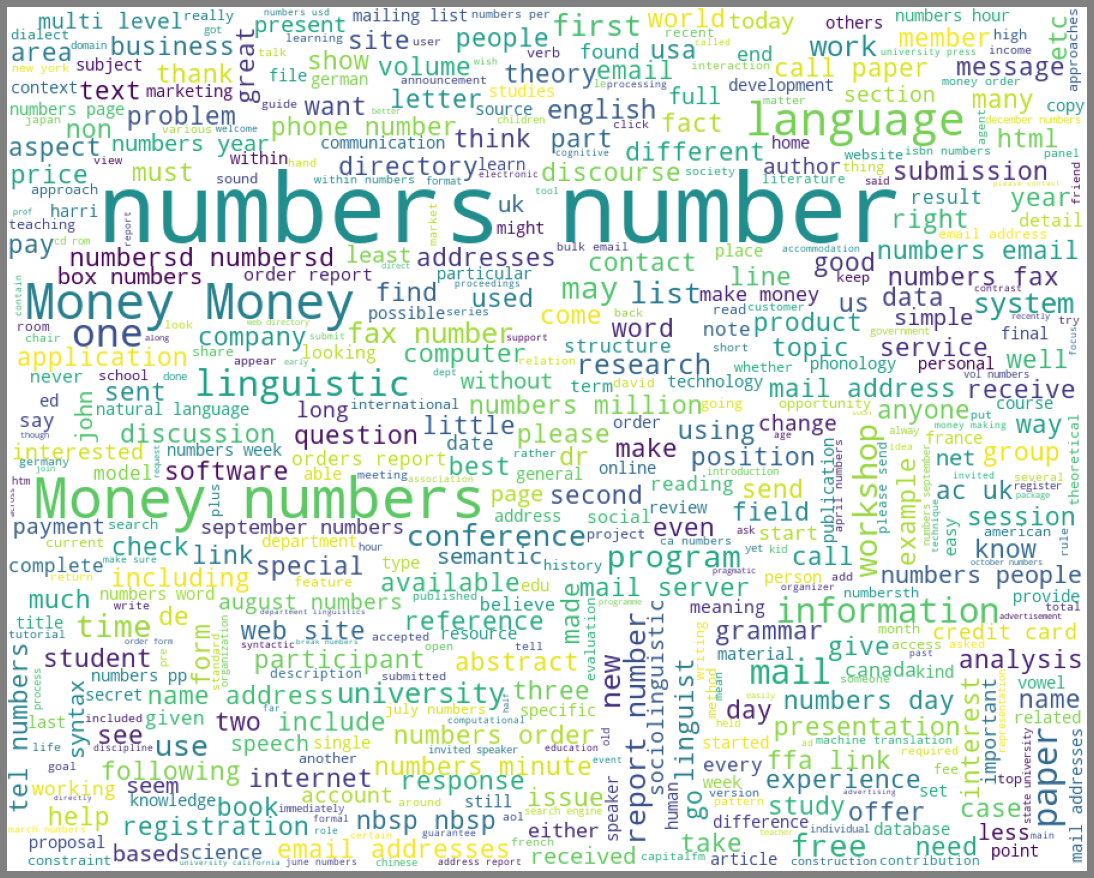

In [25]:
#WORD CLOUD FOR SPAM MAIL
SPAM = spam['mail'][spam['label']==1]
spam_cloud = wc(width=900,height=720,background_color='white',max_words=500).generate(' '.join(SPAM))
plt.figure(figsize=(15,18),facecolor='grey')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

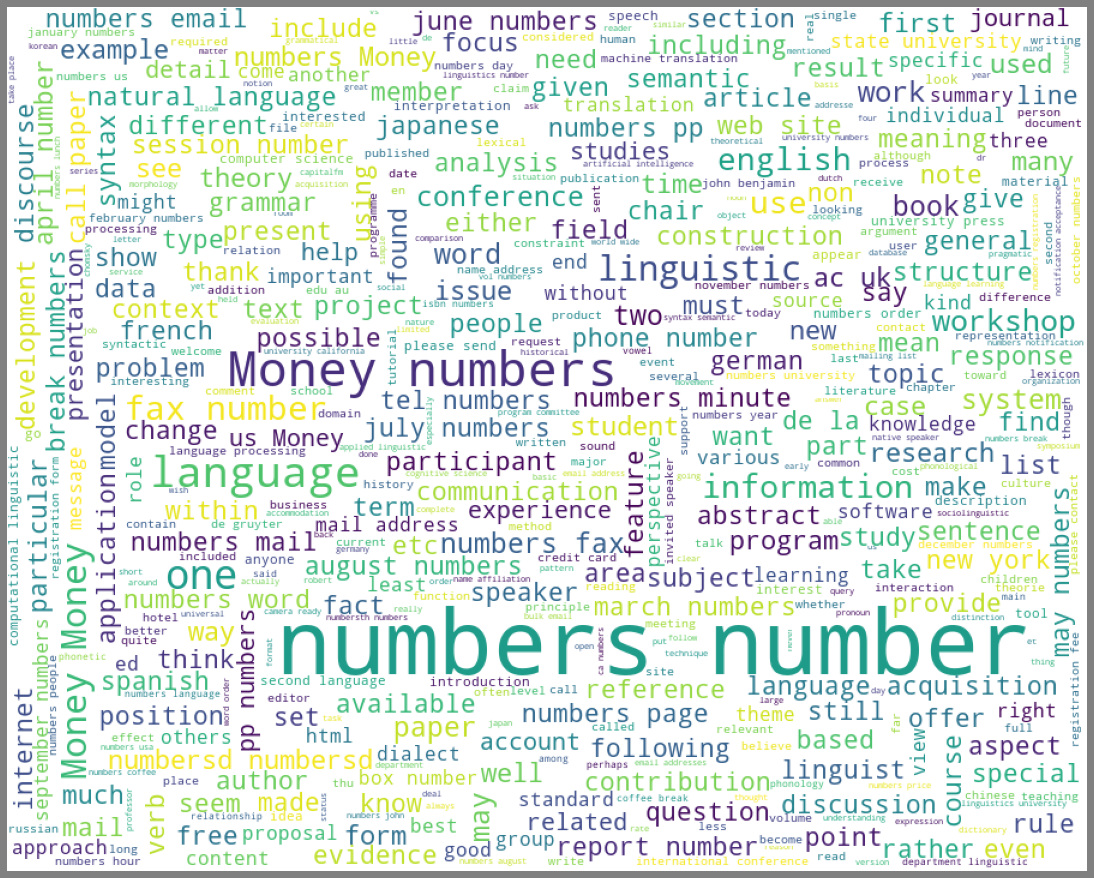

In [26]:
#WORD CLOUD FOR NOT SPAM MAIL
NO_SPAM = spam['mail'][spam['label']==0]
no_spam_cloud = wc(width=900,height=720,background_color='white',max_words=500).generate(' '.join(NO_SPAM))
plt.figure(figsize=(15,18),facecolor='grey')
plt.imshow(no_spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**MODELLING**

In [27]:
x=tfidf(input='content', encoding='utf-8', lowercase=True,stop_words='english').fit_transform(spam['mail'])
x

<2859x54819 sparse matrix of type '<class 'numpy.float64'>'
	with 465801 stored elements in Compressed Sparse Row format>

In [28]:
y=spam['label']

In [29]:
ACCURACY = []
PRECISION = []
RECALL = []
RMSE = []
MSE = []
ROC_AUC=[]

def acusr(model,x,y):
    max_ac=0
    for rst in range(25,100):
        x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=rst)
        model.fit(x_train,y_train)
        pred=model.predict(x_test)
        acc=accuracy_score(pred,y_test)
        clr=classification_report(y_test,pred)
        conf=confusion_matrix(y_test,pred)
        pre=precision_score(y_test,pred)
        rec=recall_score(y_test,pred)
        mse=mean_squared_error(y_test,pred)
        rmse=np.sqrt(mse)
        fpr, tpr, thresholds = roc_curve(y_test, pred, pos_label = 1)
        roc_auc = auc(fpr, tpr)
        if acc>max_ac:
            max_ac=acc
            final_rst=rst
         
    print("In this",model,"\nRANDOM STATE:\n",final_rst)
    print('\nACCURACY SCORE:\n', max_ac)
    print('\nCLASSIFICATION REPORT:\n',clr)
    print('\nCONFUSION MATRIX:\n',conf)
    print('\nPRECISION:\n',pre)
    print('\nRECALL:\n',rec)
    print('\nMEAN SQUARED ERROR:\n',mse)
    print('\nROOT MEAN SQ. ERROR:\n',rmse)
    print('\nROC_AUC:\n',roc_auc)

    #ADDING VALUES TO LIST
    ACCURACY.append(acc)
    PRECISION.append(pre)
    RECALL.append(rec)
    RMSE.append(rmse)
    MSE.append(mse)
    ROC_AUC.append(roc_auc)
    
   
    #PLOTTING auc_roc CURVE
    sns.set(style='whitegrid',context='talk',font_scale=0.7)
    plt.figure(figsize=(8,7),dpi=120)
    plt.plot([0,1],[0,1],color='aquamarine',linestyle=":",lw=3)
    plt.plot(fpr,tpr,label="AUC= %0.2f" % roc_auc,color='dodgerblue',lw=3,linestyle='--')
    plt.legend(loc='lower right',fontsize='medium',shadow=True)
    plt.xlabel("FPR")
    plt.ylabel('TPR')
    plt.title('RECEIVER OPERATING CHARACTERISTICS CURVE',size=15,weight='bold',loc='center')
    plt.show()
    
    
    #PLOTTING CONFUSION MATRIX
    plt.figure(figsize=(6,4),dpi=120)
    sns.heatmap(conf,annot=True,cmap='Blues')
    plt.title('HEATMAP OF CONFUSION MATRIX')
    plt.show()

**LOGISTIC REGRESSION**

In this LogisticRegression(max_iter=600, warm_start=True) 
RANDOM STATE:
 56

ACCURACY SCORE:
 0.8636363636363636

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.84      1.00      0.92       723
           1       1.00      0.01      0.01       135

    accuracy                           0.84       858
   macro avg       0.92      0.50      0.46       858
weighted avg       0.87      0.84      0.77       858


CONFUSION MATRIX:
 [[723   0]
 [134   1]]

PRECISION:
 1.0

RECALL:
 0.007407407407407408

MEAN SQUARED ERROR:
 0.1561771561771562

ROOT MEAN SQ. ERROR:
 0.39519255582204

ROC_AUC:
 0.5037037037037037


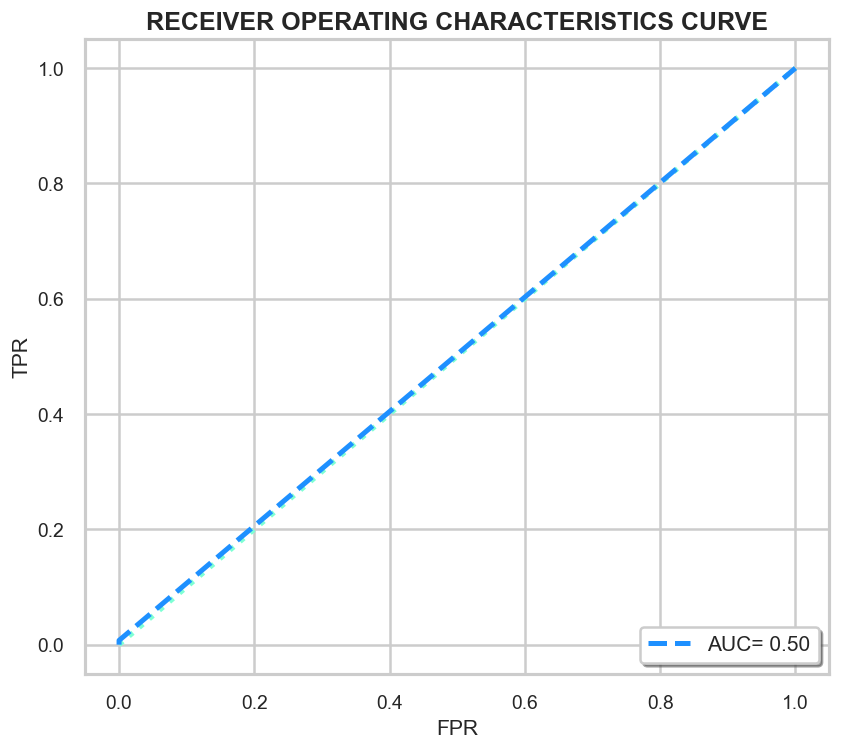

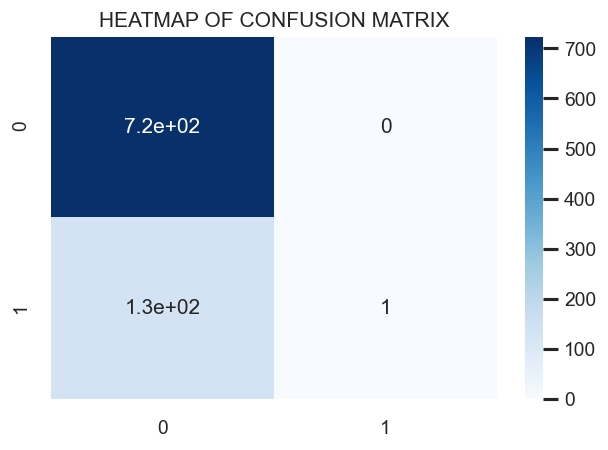

In [30]:
logi=LogisticRegression(max_iter=600,warm_start=True)
acusr(logi,x,y)

**MULTINOMIAL NB**

In [31]:
nb=MultinomialNB()
params = {'alpha': [0.1, 0.2, 0.8, 0.9, 1.0]}
mnb = gsv(nb,params,scoring='f1_weighted', cv=50)
mnb.fit(x,y)
print(mnb)
print('\nbest_score=',mnb.best_score_)
print('\nbest_parameters=',mnb.best_params_)


GridSearchCV(cv=50, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.2, 0.8, 0.9, 1.0]},
             scoring='f1_weighted')

best_score= 0.7658233785497666

best_parameters= {'alpha': 0.2}


In this MultinomialNB(alpha=0.2) 
RANDOM STATE:
 94

ACCURACY SCORE:
 0.8613053613053613

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91       723
           1       0.00      0.00      0.00       135

    accuracy                           0.84       858
   macro avg       0.42      0.50      0.46       858
weighted avg       0.71      0.84      0.77       858


CONFUSION MATRIX:
 [[720   3]
 [135   0]]

PRECISION:
 0.0

RECALL:
 0.0

MEAN SQUARED ERROR:
 0.16083916083916083

ROOT MEAN SQ. ERROR:
 0.4010475792710397

ROC_AUC:
 0.4979253112033195


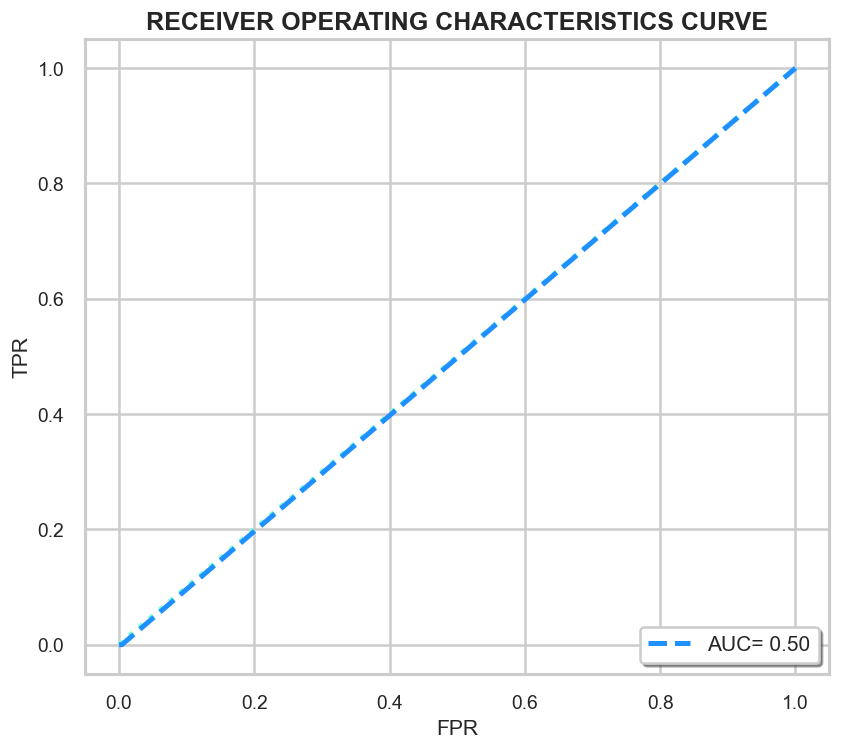

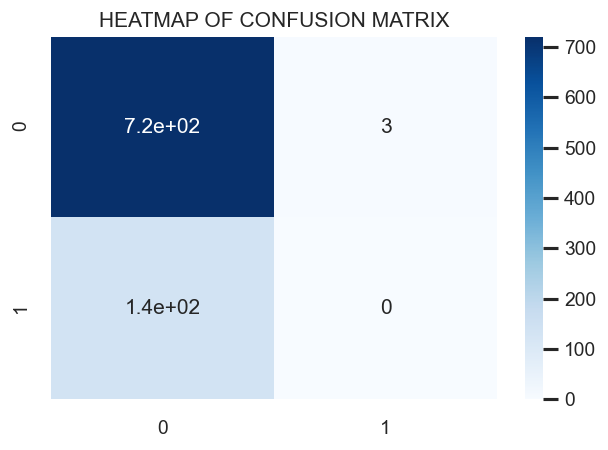

In [32]:
nb=MultinomialNB(alpha=0.2)
acusr(nb,x,y)

**COMPLEMENT NB**

In [33]:
NB_Params = {'alpha': [0.1,  0.9, 1.0]}

cnb = ComplementNB()
cnb_gsv = gsv(cnb, NB_Params, cv=20)
cnb_gsv.fit(x,y)
print(cnb_gsv)
print('\nbest_score=',cnb_gsv.best_score_)
print('\nbest_parameters=',cnb_gsv.best_params_)

GridSearchCV(cv=20, estimator=ComplementNB(),
             param_grid={'alpha': [0.1, 0.9, 1.0]})

best_score= 0.8380552546045503

best_parameters= {'alpha': 1.0}


In this ComplementNB() 
RANDOM STATE:
 56

ACCURACY SCORE:
 0.8624708624708625

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91       723
           1       0.00      0.00      0.00       135

    accuracy                           0.84       858
   macro avg       0.42      0.50      0.46       858
weighted avg       0.71      0.84      0.77       858


CONFUSION MATRIX:
 [[723   0]
 [135   0]]

PRECISION:
 0.0

RECALL:
 0.0

MEAN SQUARED ERROR:
 0.15734265734265734

ROOT MEAN SQ. ERROR:
 0.3966644140109588

ROC_AUC:
 0.5


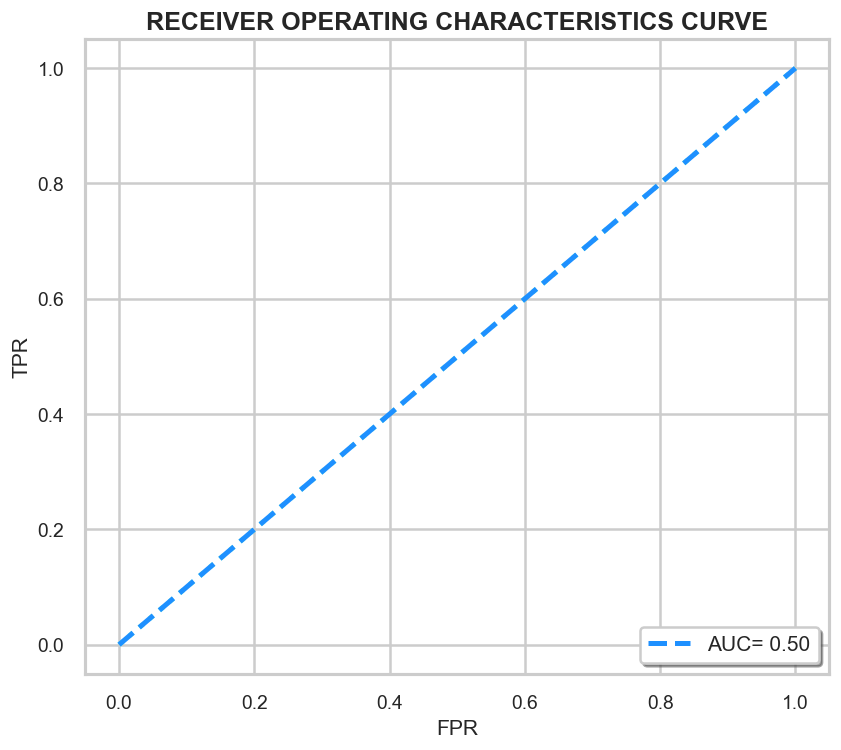

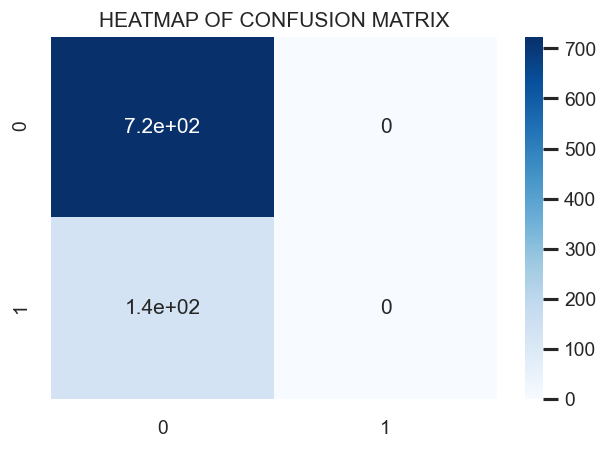

In [34]:
cnb = ComplementNB(alpha=1.0)
acusr(cnb,x,y)

**SVC**

In this SVC(degree=9, gamma=0.1, kernel='linear') 
RANDOM STATE:
 94

ACCURACY SCORE:
 0.8613053613053613

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91       723
           1       0.30      0.02      0.04       135

    accuracy                           0.84       858
   macro avg       0.57      0.51      0.48       858
weighted avg       0.76      0.84      0.77       858


CONFUSION MATRIX:
 [[716   7]
 [132   3]]

PRECISION:
 0.3

RECALL:
 0.022222222222222223

MEAN SQUARED ERROR:
 0.16200466200466201

ROOT MEAN SQ. ERROR:
 0.4024980273301498

ROC_AUC:
 0.5062701705855233


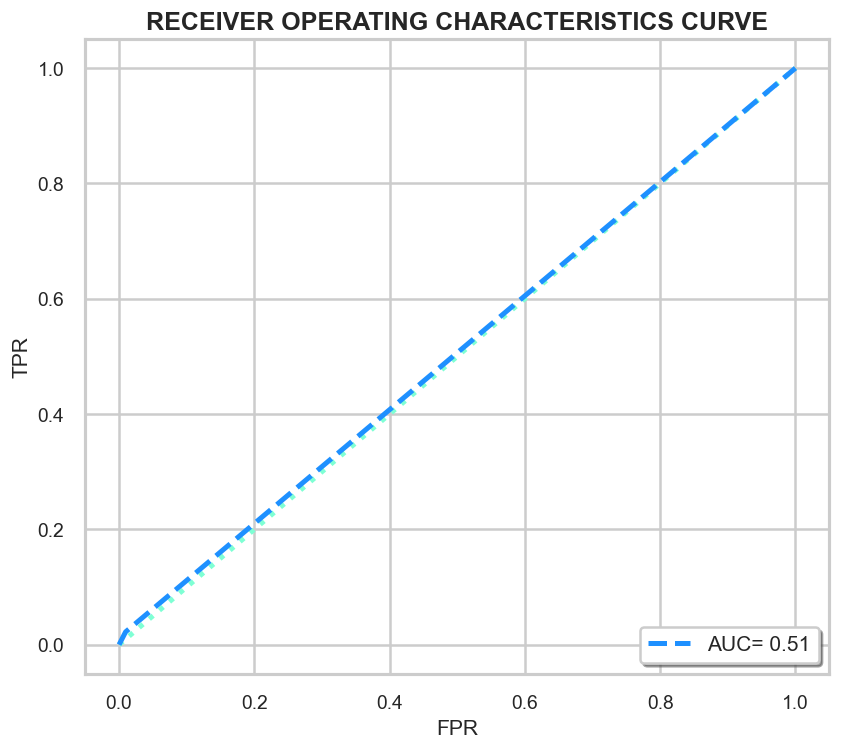

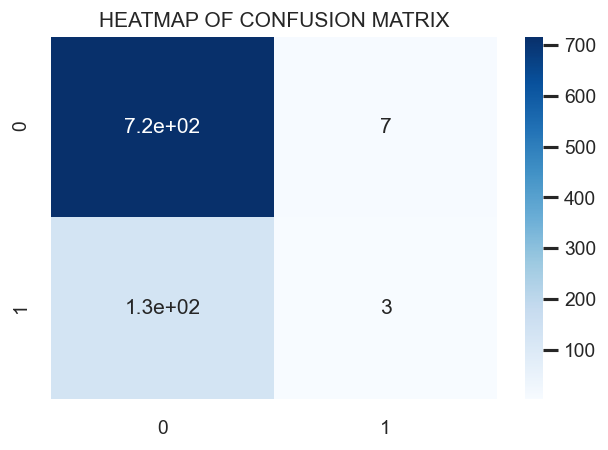

In [35]:
svc=SVC(kernel='linear',gamma=0.1,degree=9)
acusr(svc,x,y)

**RANDOM FOREST CLASSIFIER**

In [36]:
rfc=RandomForestClassifier()
rfc_para={"n_estimators":[200,350],'max_depth':[6,9],'criterion':('gini','entropy')}
rfc_gsv=gsv(rfc,rfc_para,cv=50)
rfc_gsv.fit(x,y)
print(rfc_gsv)
print('\nbest score=',rfc_gsv.best_score_)
print('\nbest parameters for RFC=\n',rfc_gsv.best_params_)

GridSearchCV(cv=50, estimator=RandomForestClassifier(),
             param_grid={'criterion': ('gini', 'entropy'), 'max_depth': [6, 9],
                         'n_estimators': [200, 350]})

best score= 0.8391288566243195

best parameters for RFC=
 {'criterion': 'gini', 'max_depth': 9, 'n_estimators': 200}


In this RandomForestClassifier(max_depth=9, n_estimators=200) 
RANDOM STATE:
 56

ACCURACY SCORE:
 0.8636363636363636

CLASSIFICATION REPORT:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91       723
           1       0.00      0.00      0.00       135

    accuracy                           0.84       858
   macro avg       0.42      0.50      0.46       858
weighted avg       0.71      0.84      0.77       858


CONFUSION MATRIX:
 [[722   1]
 [135   0]]

PRECISION:
 0.0

RECALL:
 0.0

MEAN SQUARED ERROR:
 0.1585081585081585

ROOT MEAN SQ. ERROR:
 0.3981308308937635

ROC_AUC:
 0.49930843706777317


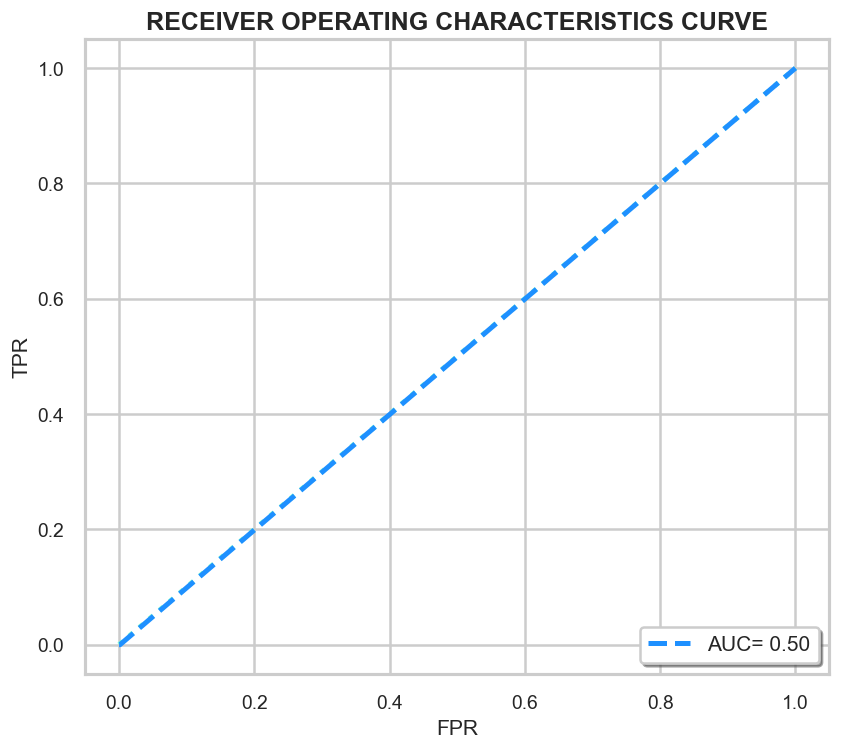

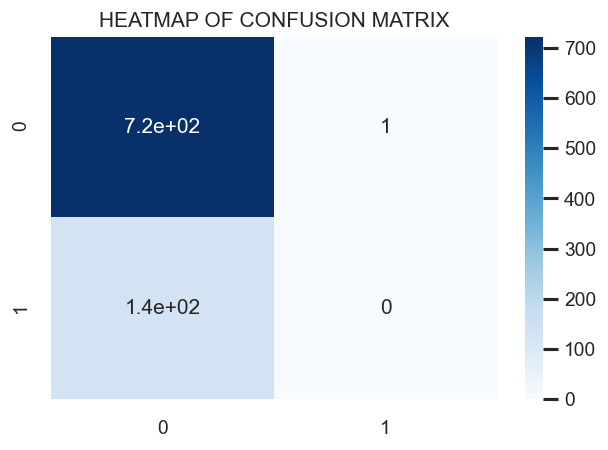

In [37]:
rfc=RandomForestClassifier(n_estimators=200,max_depth=9,criterion='gini')
acusr(rfc,x,y)

In [38]:
model=["LOGISTIC",'MNB','CNB','SVC','RANDOM FOREST']
results = pd.DataFrame({"MODEL":model,'Accuracy':ACCURACY,'Precision': PRECISION ,'Recall': RECALL,
                               'RMSE':RMSE,'MSE':MSE,"ROC_AUC":ROC_AUC})
                               
                                
            
results.style.set_properties(**{'background-color':'darkslategrey','color': 'springgreen','border-color': 'darkorange'})                                   

,MODEL,Accuracy,Precision,Recall,RMSE,MSE,ROC_AUC
0,LOGISTIC,0.843823,1.000000,0.007407,0.395193,0.156177,0.503704
1,MNB,0.839161,0.000000,0.000000,0.401048,0.160839,0.497925
2,CNB,0.842657,0.000000,0.000000,0.396664,0.157343,0.500000
3,SVC,0.837995,0.300000,0.022222,0.402498,0.162005,0.506270
4,RANDOM FOREST,0.841492,0.000000,0.000000,0.398131,0.158508,0.499308
